# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom dataset

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
torch.__version__

'2.1.2'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the image (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("Data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak and sushi data
    with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak and sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak and sushi data...")
        zip_ref.extractall(image_path)

Data/pizza_steak_sushi directory already exists... skipping download


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its content."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'Data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'Data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'Data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'Data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'Data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'Data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'Data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'Data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'Data/pizza_steak_sushi/train/sushi'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('Data/pizza_steak_sushi/train'),
 PosixPath('Data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.patent.stem`
4. Since we're working with image, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: Data/pizza_steak_sushi/test/sushi/2741434.jpg
Image class: sushi
Image height: 512
Image width: 512


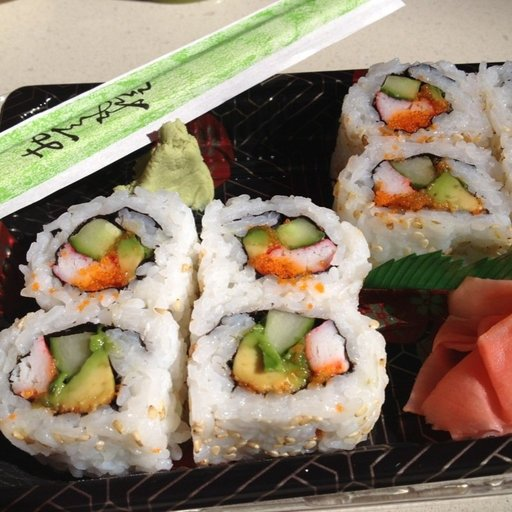

In [6]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name (the image class is the name of directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

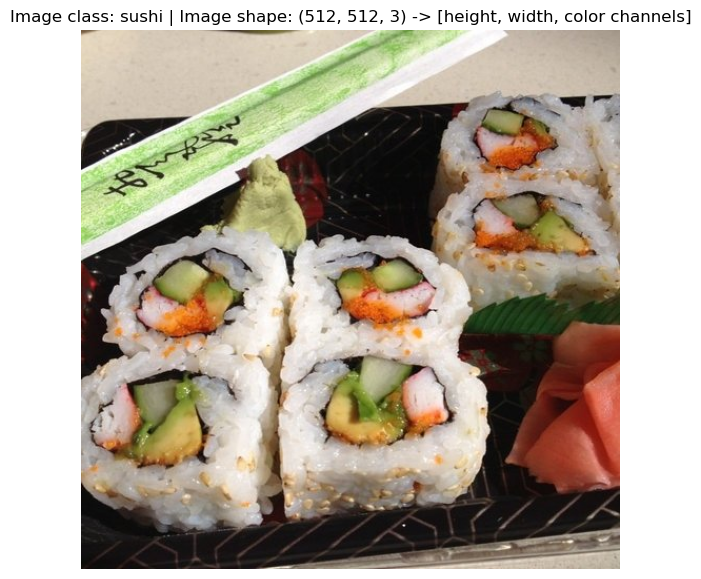

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False)

In [8]:
img_as_array

array([[[120,  94,  67],
        [120,  94,  67],
        [120,  94,  67],
        ...,
        [161, 149, 135],
        [161, 149, 135],
        [162, 150, 136]],

       [[122,  96,  69],
        [121,  95,  68],
        [120,  94,  67],
        ...,
        [162, 150, 136],
        [163, 151, 137],
        [164, 152, 138]],

       [[131, 107,  81],
        [133, 109,  83],
        [136, 112,  86],
        ...,
        [164, 152, 138],
        [165, 153, 139],
        [166, 154, 140]],

       ...,

       [[ 18,  15,  10],
        [ 18,  15,  10],
        [ 19,  14,  10],
        ...,
        [177, 168, 151],
        [183, 176, 158],
        [181, 174, 156]],

       [[ 20,  15,   9],
        [ 22,  17,  11],
        [ 28,  20,  17],
        ...,
        [177, 168, 151],
        [178, 171, 153],
        [175, 168, 150]],

       [[ 21,  16,  10],
        [ 27,  22,  16],
        [ 35,  27,  24],
        ...,
        [186, 177, 160],
        [181, 174, 156],
        [175, 168, 150]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of out images).
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

[Transforms](https://pytorch.org/vision/stable/transforms.html) help you get your images ready to be used with a model/perform data augmentation.

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize out images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

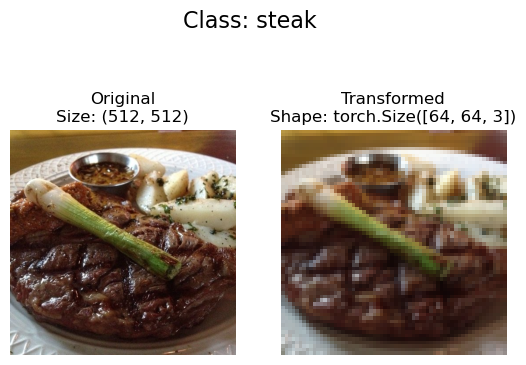

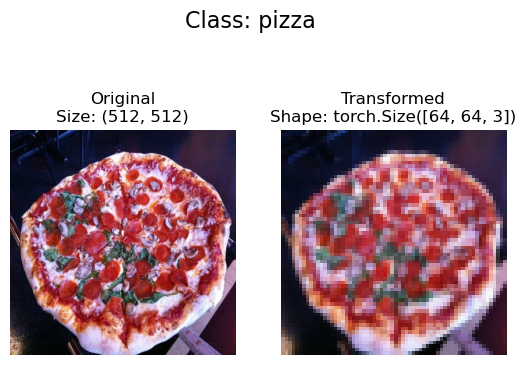

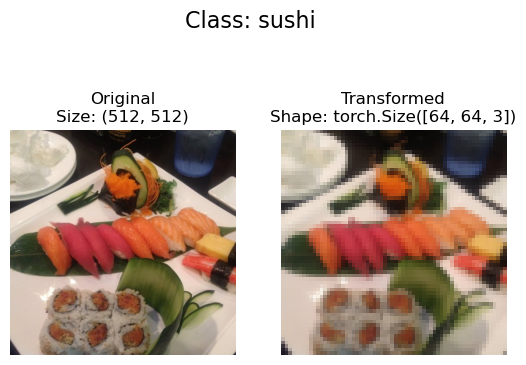

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms them,
    then plots the original vs transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            ## Note: we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data `ImgeFolder`

We can load image classification data using [`torchvision.dataset.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [13]:
# Use image folder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: Data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
train_dir, test_dir

(PosixPath('Data/pizza_steak_sushi/train'),
 PosixPath('Data/pizza_steak_sushi/test'))

In [15]:
# Get class name as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('Data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width,color_channels]


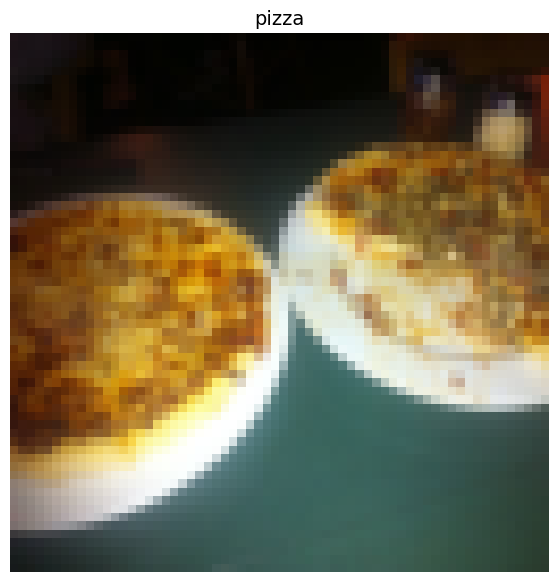

In [20]:
# Rearrange the order of dimension
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width,color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [21]:
import os
os.cpu_count()

12

In [22]:
# Turn train and test dataset into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd240c9abc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd240c35690>)

In [23]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - [Link](https://pytorch.org/docs/stable/data.html)

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found. (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [27]:
# Setup path for directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_name_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_name_found

Target dir: Data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

    # 3. Create a dictionary of index labels (computers prefer numbers rather than string as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [30]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Inti our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index


In [31]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        # 3. Create class attributes
        # Get all of the image path
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(directory=targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Return the total number of samples."""
        return len(self.paths)

    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name #expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed image and label

In [32]:
# Create a transform
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [37]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of a random sample indexes from the targe dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [38]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimension for plotting
        # [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

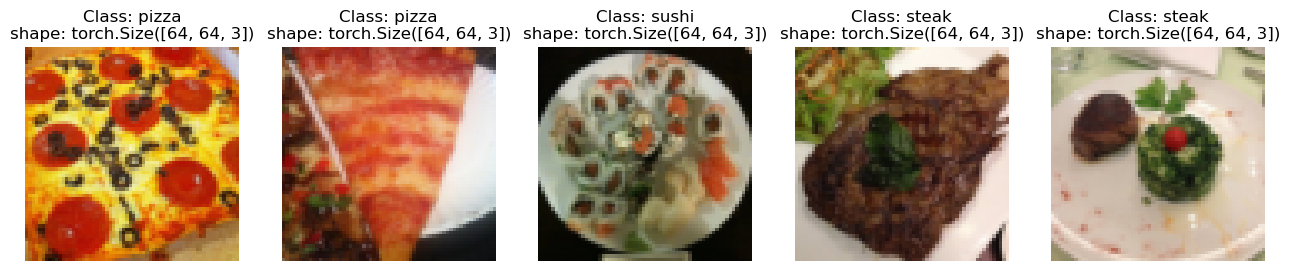

In [39]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


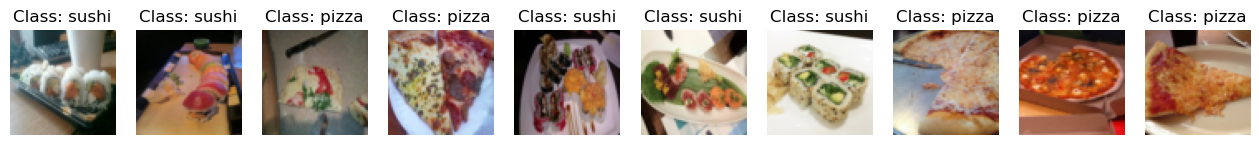

In [40]:
# Display random images from the ImageFolderCustom created Dataset
display_random_images(dataset=train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fd240c9ada0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd2402dfc70>)

In [42]:
# Get image and label from custom dataloader
img_custom, label_custom =  next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))